In [1]:
# Setting the PythonPath
import os
import sys

import torch

# # Get the parent directory of the current working directory
root_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Add the current directory to PYTHONPATH
if root_dir not in sys.path:
    sys.path.append(root_dir)
root_dir

'/home/local/USHERBROOKE/aara2601/projects/qombating-fires'

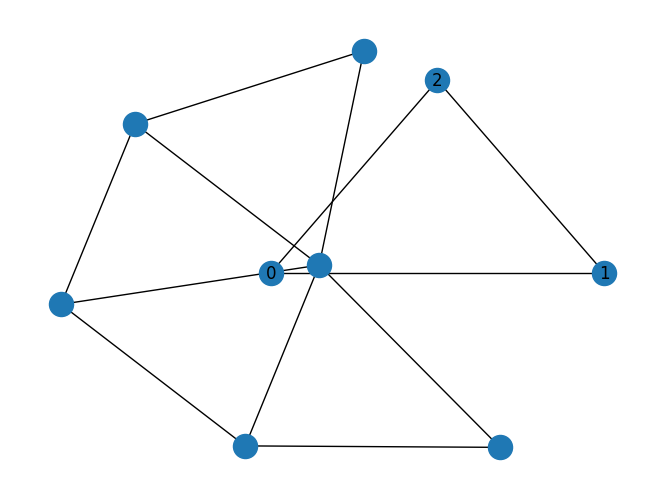

In [8]:
from qadence import QuantumCircuit
import networkx as nx
from bassir.models.quantum_kernel.quantum_utils import get_default_register_topology, get_register_from_sub_nodes

traps = get_default_register_topology(topology='triangular_lattice', n_cells_row=2, n_cells_col=2)

sub_nodes = list(traps.nodes)[:3]

reg = get_register_from_sub_nodes(sub_nodes=sub_nodes, traps=traps)
nx.draw(traps)
reg.draw()

6

### Evolving the set of sub-register

In [80]:
from qadence import VariationalParameter, AnalogRot, run, RydbergDevice, BackendName, zero_state

omega = VariationalParameter("Omega")
delta = VariationalParameter("delta")
phi = VariationalParameter("phi")
t = VariationalParameter("t")


# This implements evolves Hamiltonian  H(R(x)) / h = ∑ᵢ(Ω/2 cos(φ)*Xᵢ - sin(φ)*Yᵢ - δnᵢ) + Hᵢₙₜ for a duration t
# operator_uvttx = exp(-i t H(R(x))) 
operator_uvttx = AnalogRot(
    duration = t, # [ns]
    omega = omega, # [rad/μs]
    delta = delta, # [rad/μs]
    phase = phi, # [rad]
)

# Zero state initialization
init_state = zero_state(n_qubits = reg.n_qubits)

#
psi_vttx = run(
    reg,                                # The quantum system
    operator_uvttx,                     # The applied operator
    state = init_state,                 # The initialization
    backend = BackendName.PYQTORCH      # The used backend
)

# The resulting state \ket\{\psi_{tt}}(\bx)
psi_vttx

tensor([[ 1.0000e+00-1.9580e-11j, -6.7491e-05-2.8179e-04j,
         -6.7491e-05-2.8179e-04j,  1.2222e-10+2.4225e-10j,
         -6.7491e-05-2.8179e-04j,  1.2222e-10+2.4225e-10j,
          1.2222e-10+2.4225e-10j, -8.2022e-17-9.7103e-17j]])

In [101]:
from qadence import QuantumCircuit, hamiltonian_factory, DiffMode, QuantumModel, N
from bassir.models.quantum_kernel.quantum_utils import get_default_register_topology, get_register_from_sub_nodes

traps = get_default_register_topology(topology='triangular_lattice', n_cells_row=3, n_cells_col=3)
sub_nodes = list(traps.nodes)
sub_reg = get_register_from_sub_nodes(sub_nodes=sub_nodes, traps=traps)
        


omega = VariationalParameter("Omega")
delta = VariationalParameter("delta")
phi = VariationalParameter("phi")
t = VariationalParameter("t")


# This implements evolves Hamiltonian  H(R(x)) / h = ∑ᵢ(Ω/2 cos(φ)*Xᵢ - sin(φ)*Yᵢ - δnᵢ) + Hᵢₙₜ for a duration t
# operator_uvttx = exp(-i t H(R(x))) 
operator_uvttx = AnalogRot(
    duration = t, # [ns]
    omega = omega, # [rad/μs]
    delta = delta, # [rad/μs]
    phase = phi, # [rad]
)

# our observable \cO_x
observable = hamiltonian_factory(sub_reg.n_qubits, detuning = N)

# Defining the circuit and observable
circuit = QuantumCircuit(sub_reg, operator_uvttx)

# The resulting state \ket\{\psi_{tt}}(\bx)
psi_ttx = QuantumModel(
    circuit,
    observable = observable,
    backend = BackendName.PYQTORCH,
    diff_mode = DiffMode.AD
).to('cuda')()

psi_ttx

tensor([[ 1.0000e+00-3.4286e-11j, -1.4266e-04-1.3597e-04j,
         -1.4266e-04-1.3597e-04j,  ...,
          1.9639e-52-1.2046e-51j,  1.9639e-52-1.2046e-51j,
          1.8959e-58+2.6564e-58j]], device='cuda:0', grad_fn=<TBackward0>)

## Fitting a function

In [56]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

def binary_activation(logits: Tensor, tau: float = 1.0, threshold: float = 0.5) -> Tensor:
    """
    Applies a relaxed binary (Bernoulli) activation on logits using a relaxed Bernoulli (Binary Concrete)
    distribution, thresholds the values, and ensures that at least one entry is 1.

    :param logits: The input logits tensor.
    :param tau: Temperature for the relaxed Bernoulli distribution.
    :param threshold: Threshold value to convert relaxed values into hard binary outputs.
    :return: A tensor of the same shape as logits with binary values (0s and 1s) that is differentiable.
    """
    # Define the relaxed Bernoulli distribution and sample using the reparameterization trick.
    dist = torch.distributions.RelaxedBernoulli(temperature=tau, logits=logits)
    y = dist.rsample()

    # Hard threshold to obtain binary outputs.
    y_hard = (y > threshold).float()

    # Check if all entries in the sample are zero.
    all_zero = (y_hard.sum(dim=-1, keepdim=True) == 0)
    if all_zero.any():
        # Force at least one active element by setting the index with the maximum logit to 1.
        max_indices = torch.argmax(logits, dim=-1)
        one_hot = F.one_hot(max_indices, num_classes=logits.size(-1)).float()
        y_hard = y_hard + all_zero.float() * one_hot
        y_hard = (y_hard > threshold).float()
    
    # Use the straight-through estimator: use hard values for forward pass while keeping gradients from y.
    return (y_hard - y).detach() + y


class SmallNN(nn.Module):
    def __init__(self, dim: int, traps, tau: float = 1.0):
        """
        :param dim: Input feature dimension.
        :param traps: Graph representing the available trap locations.
        :param tau: Temperature for the binary activation.
        """
        super().__init__()
        self.traps = traps
        self.dim = dim 
        self.tau = tau
        self.fc = nn.Linear(dim, len(traps))
        
    def forward(self, x: Tensor) -> Tensor:
        logits = self.fc(x)
        out = binary_activation(logits, tau=self.tau)
        return out

In [78]:
from bassir.models.quantum_kernel.quantum_utils import get_default_register_topology, get_register_from_sub_nodes

traps = get_default_register_topology(topology='triangular_lattice', n_cells_row=2, n_cells_col=2)
dim = 12

smallNN = SmallNN(dim, traps)
batch = 4
x = torch.rand((batch, dim))

smallNN(x)

tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1.]], grad_fn=<AddBackward0>)

In [ ]:
from qadence import N, hamiltonian_factory, VariationalParameter, QuantumModel, DiffMode, AbstractBlock, Register, FeatureParameter

class Bassir(nn.Module):
    def __init__(self, dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.traps = get_default_register_topology(topology='triangular_lattice', n_cells_row=2, n_cells_col=2)
        self.smallNN = SmallNN(dim, traps)
        
        # Variational Parameters
        self.omega = VariationalParameter("Omega")
        self.delta = VariationalParameter("delta")
        self.phi = VariationalParameter("phi")
        self.t = VariationalParameter("t")
        
        # Feature map
        self.operator_uvttx = AnalogRot(
            duration = t, # [ns]
            omega = omega, # [rad/μs]
            delta = delta, # [rad/μs]
            phase = phi, # [rad]
        )
        
        # our observable \cO_x
        self.observable = hamiltonian_factory(len(self.traps), detuning = N)
        
        # Todo, find a way to fix the model but deactivate qubits on the trap in a flexible way !!! 
        self.qm = QuantumModel(
            circuit = QuantumCircuit(self.traps, self.operator_uvttx),
            observable = self.observable,
            backend = BackendName.PYQTORCH,
            diff_mode = DiffMode.AD
        )
        
    def forward(self, x):
        sub_nodes = self.smallNN(x) 
        sub_reg = get_register_from_sub_nodes(sub_nodes=sub_nodes, traps=traps)
        
        ketpsi_tt = self.qm.circuit()
        
        return probs

In [17]:
type(model)

qadence.model.QuantumModel